# Energy prediction - R soultion translated to Python and fully reproduced

The aim of this jupyter notebook is to translate the regression problem project concerning energy consumption prediction from R to Python language. In this file we would like to reproduce the original project's results as accurately as possible. We reconstruct all steps done by author in the original work.

Later on, this notebook is a basis for further improvements - errors/inconsistencies found in original code are also visible here, we will correct them and extend the analysis in the later steps.

Below find the description of the data:

The Energy dataset consists of energy use in Watt-hours in a house denoted every 10 minutes. The period of measurement lasted 4,5 months.

The main attributes are:
- The temperature in every room of a house
- Humidity in every room of a house
- Temperature outside
- Humidity outside
- Pressure
- Wind speed
- Visibility
- 2 random variables
- Time 


For the regression problem two algorithms were used: XGBoost and Convolutional Neural Networks.

#### IMPORTANT! Before libraries import we set appropriate seeds in order to provide full reproducibility (including CNN calculations).

We follow the instructions outlined here: https://keras.io/getting_started/faq/ (section `How can I obtain reproducible results using Keras during development?`) and here: https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ (section `Seed Random Numbers with the TensorFlow Backend`).

In [49]:
from numpy.random import seed
from tensorflow.random import set_seed
import random as python_random

seed(123)
python_random.seed(123)
set_seed(123)

## 1. Import libraries used in the analysis

In [50]:
# basic libraries
import pandas as pd
pd.set_option('display.max_columns',None) #setting to see all columns

import numpy as np
#from numpy.random import seed #random seed - used to get reproducible results

import matplotlib as mpl
import matplotlib.pyplot as plt

# datetime - used in feature engineering part
import datetime

# modelling - sklearn 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# modelling - xgboost
from xgboost import XGBRegressor

# modelling - deep neural nets
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers

In [51]:
# load data
data = pd.read_csv('../data/energydata_complete.csv')

## 2. Exploratory Data Analysis

Check for any missing data

In [52]:
data.isnull().values.sum()

0

No missing values

Prepare summary of numerical features

In [53]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


Check types of columns present in the dataset

In [54]:
data.dtypes

date            object
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
dtype: object

## 3. Feature Engineering

Almost all varaibles are numeric data type.

We are going to transform the `date` variable (in fact, it is a column with date-time information).
As feature engineering part of the analysis, we extract from the `date` variable following features:

* `year`
* `month`
* `day`
* `hour`
* `minute`
* `second`

In [55]:
# first we have to convert the date from object to datetime - in R it is originally a datetime format
data['date'] = pd.to_datetime(data['date'])

# prepare variables based on the date variable
data['year'] = data['date'].dt.year   # worth noting - all observations in year 2016
data['month'] = data['date'].dt.month     
data['day'] = data['date'].dt.day     
data['hour'] = data['date'].dt.hour     
data['minute'] = data['date'].dt.minute
data['second'] = data['date'].dt.second # worth noting - observations taken in 10-minutes intervals - all observation of `second` variable == 0!

In [56]:
data.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,year,month,day,hour,minute,second
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,2016,5,27,17,20,0
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,2016,5,27,17,30,0
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,2016,5,27,17,40,0
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,2016,5,27,17,50,0
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851,2016,5,27,18,0,0


We also add three additional variables concerning the day of the week, hour of the day and time of the day (morning, afternoon or evening).

As we follow the original work - we create a day of week variable as a string with name of the day.

Moreover, originally the author created once more the same variable - hour of the day (columns `hour` and `hour_of_day`). As our aim is to reproduce the results as closely as possible, we do so here. Yet, we are going to take that into account in improved version of the analysis.

In [57]:
# create weekday variable
data['day_of_week'] = data['date'].dt.strftime('%A')

# create once more the variable concerning hour of the day
data['hour_of_day'] = data['date'].dt.hour 

# create feature concerning time of the day - we follow rules set in the original work
condlist_ = [(data['hour_of_day'] >= 6)  &  (data['hour_of_day']  < 12), 
             (data['hour_of_day']) >= 12 &  (data['hour_of_day']  < 18)]

choicelist_ = ['morning', 
               'afternoon']

data['time_of_day'] = np.select(condlist_, choicelist_, default='evening')

we select only numeric features. As we follow the original work, this way we exclude from the analysis variables `day_of_week` and `time_of_day`. We are going to account for these variables in improved version of the project.

In [58]:
data_numeric = data.select_dtypes(include=np.number)

Now we remove some of the variables - the same ones as in the original R solution. We remove:

* random variables (`rv1`, `rv2`)
* zero-variance variables (noted earlier `year` and `second` variables)
* duplicated feature concerning the hour of the day (`hour_of_day`) variable

In [59]:
# as in original work - we exclude some of newly created columns and also duplicate hour of day
data_numeric.drop(columns=['second', 'year', 'hour_of_day', 'rv1', 'rv2'], inplace=True)

This way we end the feature engineering part and move on to the feature selection.

## 4. Feature Selection

In this section we extensively use linear regression models and the VIF values in order to select variables in a way to handle the multicollinearity issues.

We continually calculate linear regression models and perform VIF analysis until all remaining features have VIF < 4.

For the sake of the feature selection, we use the function, which was provided by one of the users of StackOverflow. We slightly modify the original function to tailor it to our needs (we do not calculate tolerance factor and we change the names of the arguments passed to the function).

Exact source: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
Answer provided by user `steven`, on Feb 24, 2019 at 23:06

In [60]:
# source: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
def sklearn_vif(predictors, data):
    
    '''Return VIF (variance inflation factor) DataFrame

    Args:
    predictors (list): list of independent variables (predictors), for which we would like to calculate VIF
    data (DataFrame): the df storing all variables

    Returns:
    VIF DataFrame for each independent variable

    Notes:
    Assume we have a list of independent variable [X1, X2, X3, X4].
    To calculate the VIF for each variable, we regress
    each of them against other independent variables. For instance, the
    regression model for X3 is defined as:
                        X3 ~ X1 + X2 + X4
    And then we extract the R-squared from the model to calculate:
                    VIF = 1 / (1 - R-squared)
    The cutoff to detect multicollinearity:
                    VIF > 4 (In our case, other known benchmarks are VIF > 5/7/10 etc.)
    '''
    
    # initialize dictionaries
    vif_dict = {}

    # form input data for each independent variable
    for predictor in predictors:
        not_predictor = [i for i in predictors if i != predictor]
        X, y = data[not_predictor], data[predictor]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[predictor] = vif

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict})

    return df_vif


We calculate series of models and exclude variables with highest VIF manually - as in the original work. We are going to automate the feature selection mechanism in the improved version of the analysis.

Removing the variables from the dataset makes troubles if we want to rerun parts of code more than one time. We are going to also account for it in the improved version of the analysis.

In [61]:
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.464730
RH_1,16.239051
RH_2,21.922244
RH_3,11.255109
RH_4,17.776217
RH_5,1.400071
RH_6,13.003826
RH_7,10.879662
RH_8,9.457181
RH_9,7.391118


We remove `TDewpoint` (as in original work, yet the highest VIF visible for variable `T_out` - this fact favours the automation of decision making - we are going to make use of it in improved analysis).

In [62]:
data_numeric.drop(columns=['Tdewpoint'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.460025
RH_1,16.203174
RH_2,21.601697
RH_3,11.171902
RH_4,17.717111
RH_5,1.398796
RH_6,12.244611
RH_7,10.799994
RH_8,9.449239
RH_9,7.385258


We remove `T9` (as in original work, again the highest VIF visible for variable `T_out`).

In [63]:
data_numeric.drop(columns=['T9'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.426513
RH_1,16.166139
RH_2,20.895063
RH_3,11.084838
RH_4,17.689014
RH_5,1.385681
RH_6,12.236508
RH_7,10.299071
RH_8,9.436128
RH_9,7.260331


We remove `month` (as in original work, again the highest VIF visible for variable `T_out`, also `T6` has higher VIF than `month`).

In [64]:
data_numeric.drop(columns=['month'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.426393
RH_1,16.162508
RH_2,20.762696
RH_3,10.584466
RH_4,17.557368
RH_5,1.380347
RH_6,9.265411
RH_7,10.269399
RH_8,9.383782
RH_9,7.036367


We remove `T6` (as in original work, again the highest VIF visible for variable `T_out`).

In [65]:
data_numeric.drop(columns=['T6'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.402104
RH_1,16.157600
RH_2,20.595427
RH_3,10.456049
RH_4,17.519369
RH_5,1.380047
RH_6,8.322794
RH_7,10.266961
RH_8,9.245667
RH_9,7.031271


We remove `T2` (as in original work, this time it is the variable having the highest VIF).

In [66]:
data_numeric.drop(columns=['T2'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.396373
RH_1,10.228405
RH_2,5.680558
RH_3,10.374766
RH_4,15.990400
RH_5,1.377889
RH_6,8.163944
RH_7,10.242051
RH_8,9.105107
RH_9,7.024894


We remove `T7` (as in original work, but the highest VIF visible for variable `RH_4`).

In [67]:
data_numeric.drop(columns=['T7'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.394976
RH_1,10.220617
RH_2,5.658437
RH_3,10.355720
RH_4,15.684232
RH_5,1.371535
RH_6,8.097047
RH_7,9.095500
RH_8,7.709168
RH_9,6.649379


We remove `RH_4` (as in original work, this time it is the variable having the highest VIF).

In [68]:
data_numeric.drop(columns=['RH_4'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.389033
RH_1,9.060886
RH_2,5.656632
RH_3,9.700581
RH_5,1.370189
RH_6,8.080068
RH_7,8.649982
RH_8,7.575705
RH_9,6.370897
RH_out,5.703928


We remove `RH_1` (as in original work, but the highest VIF visible for variable `T1`).

In [69]:
data_numeric.drop(columns=['RH_1'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.377984
RH_2,3.976584
RH_3,7.131440
RH_5,1.370004
RH_6,8.037909
RH_7,8.643089
RH_8,7.575378
RH_9,6.370429
RH_out,5.703336
T1,11.031983


We remove `T1` (as in original work, this time it is the variable having the highest VIF).

In [70]:
data_numeric.drop(columns=['T1'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.364041
RH_2,3.414420
RH_3,7.044575
RH_5,1.369071
RH_6,7.724339
RH_7,8.541829
RH_8,7.560079
RH_9,6.360666
RH_out,5.701326
T3,7.666880


We remove `RH_7` (as in original work, this time it is the variable having the highest VIF).

In [71]:
data_numeric.drop(columns=['RH_7'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.338596
RH_2,3.411176
RH_3,6.722693
RH_5,1.367748
RH_6,7.711453
RH_8,6.478185
RH_9,6.003080
RH_out,5.367629
T3,7.597052
T4,6.409991


We remove `RH_3` (as in original work, but the highest VIF visible for variable `T5`).

In [72]:
data_numeric.drop(columns=['RH_3'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.329558
RH_2,3.015584
RH_5,1.358897
RH_6,7.086494
RH_8,5.643430
RH_9,5.176528
RH_out,4.837805
T3,7.522516
T4,6.365598
T5,7.738681


We remove `RH_8` (as in original work, but the highest VIF visible for variable `T3`).

In [73]:
data_numeric.drop(columns=['RH_8'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.320765
RH_2,3.006528
RH_5,1.274134
RH_6,6.693841
RH_9,3.807992
RH_out,4.562813
T3,7.514524
T4,6.349965
T5,7.722300
T8,4.476773


We remove `T5` (as in original work, this time it is the variable having the highest VIF).

In [74]:
data_numeric.drop(columns=['T5'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.320746
RH_2,2.976107
RH_5,1.196108
RH_6,6.675042
RH_9,3.806224
RH_out,4.539052
T3,6.629272
T4,5.422683
T8,4.062784
T_out,5.067372


We remove `RH_6` (as in original work, this time it is the variable having the highest VIF).

In [75]:
data_numeric.drop(columns=['RH_6'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.282787
RH_2,2.972224
RH_5,1.186723
RH_9,2.960923
RH_out,3.829186
T3,6.215141
T4,5.373990
T8,3.965067
T_out,4.581673
Visibility,1.025420


We remove `T3` (as in original work, this time it is the variable having the highest VIF).

In [76]:
data_numeric.drop(columns=['T3'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.272732
RH_2,2.937746
RH_5,1.180138
RH_9,2.931936
RH_out,3.804427
T4,4.171046
T8,3.231051
T_out,4.185614
Visibility,1.022848
Windspeed,1.492864


We remove `RH_2` (as in original work, but the highest VIF visible for variable `T_out`).

In [77]:
data_numeric.drop(columns=['RH_2'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.255056
RH_5,1.178371
RH_9,2.383030
RH_out,2.795487
T4,4.153096
T8,3.175438
T_out,4.021220
Visibility,1.019055
Windspeed,1.492643
day,1.068091


In original work, tha author decided to remove the `minute` variable. It is variable with lowest VIF (the decision is disputable - probably removing `T4` is more sensible) - yet we follow the original work's logic. As stated earlier, we will prepare an automatic feature selection process in improved version of analysis. For now, we remove the `minute` variable.

In [78]:
data_numeric.drop(columns=['minute'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.255055
RH_5,1.178369
RH_9,2.383029
RH_out,2.795486
T4,4.153095
T8,3.175438
T_out,4.021218
Visibility,1.019055
Windspeed,1.492642
day,1.068091


We remove `T4` (as in original work, this time it is the variable having the highest VIF).

In [79]:
data_numeric.drop(columns=['T4'], inplace=True)
predictors_ = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()
sklearn_vif(predictors=predictors_, data=data_numeric)

,VIF
Press_mm_hg,1.245576
RH_5,1.177561
RH_9,2.382939
RH_out,2.790682
T8,1.823867
T_out,3.307385
Visibility,1.011820
Windspeed,1.419863
day,1.067527
hour,1.393872


We end the variables' removal, as for all remaining features we obtain VIF < 4.

At the end of this section, we prepare a correlogram for remaining features. 

In [80]:
data_numeric.corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,Appliances,lights,RH_5,T8,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,day,hour
Appliances,1.00,0.20,0.01,0.04,-0.05,0.10,-0.03,-0.15,0.09,0.00,0.00,0.22
lights,0.20,1.00,0.14,-0.07,-0.01,-0.07,-0.01,0.07,0.06,0.02,-0.04,0.26
RH_5,0.01,0.14,1.00,-0.09,0.27,-0.05,-0.12,0.19,0.08,-0.01,-0.04,0.10
T8,0.04,-0.07,-0.09,1.00,-0.16,0.50,-0.16,-0.30,-0.22,-0.06,-0.11,0.11
RH_9,-0.05,-0.01,0.27,-0.16,1.00,0.22,-0.18,0.36,0.24,0.01,-0.06,-0.27
T_out,0.10,-0.07,-0.05,0.50,0.22,1.00,-0.14,-0.57,0.19,-0.08,-0.10,0.22
Press_mm_hg,-0.03,-0.01,-0.12,-0.16,-0.18,-0.14,1.00,-0.09,-0.24,0.04,0.18,-0.01
RH_out,-0.15,0.07,0.19,-0.30,0.36,-0.57,-0.09,1.00,-0.18,0.08,0.07,-0.35
Windspeed,0.09,0.06,0.08,-0.22,0.24,0.19,-0.24,-0.18,1.00,-0.01,0.03,0.10
Visibility,0.00,0.02,-0.01,-0.06,0.01,-0.08,0.04,0.08,-0.01,1.00,0.01,-0.02


That's all for the feature selection part. Let's move on to modelling!

## 5. Modelling

Before the modelling, the author of original R solution removes excess variables from the `data` dataset. We follow all the steps present in original work. At the same time, we indicate there are inconsistencies / redundant operations made both on `data` and `data_numeric` datasets. Moreover, we divide the original work into sections, but we can see some data preparation / transformation steps made in modelling part - we also account for it in the improved version of analysis.

In [81]:
# drop excess variables from original dataset
data.drop(columns=['date', 'day_of_week', 'time_of_day'], inplace=True)

# Create a vector of predictors
predictors = data_numeric.columns[~data_numeric.columns.isin(['Appliances'])].tolist()

We scale the independent variables as in the original work. We use `StandardScaler`, which is a python counterpart to R `scale` function

In [82]:
# create subset data to include only independent variables
subset_data = data_numeric[predictors]

# Standardize the predictors
subset_data = StandardScaler().fit_transform(subset_data)
subset_data = pd.DataFrame(subset_data)

# we add the standardized features to data_numeric object
data_numeric[predictors] = subset_data

### 5.1. XGBoost model

We divide our dataset with ratio 80/20. 

We follow pattern made in original work - the observarions are assigned randomly to the training and test sets (we are going to change that in improved version of analysis, as we are dealing with time-series data).

Again, in original work the `data` and `data_numeric` objects are mixed/overwritten (also predictors and target variable) - we are going to fix it in improved version.

In [83]:
data = data_numeric
train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

predictors = data.columns.tolist()[2:]
response = "Appliances"

X_train = train_data[predictors]
y_train = train_data[response]

X_test = test_data[predictors]
y_test = test_data[response]

We train XGBoost model. We use the set of hyperparameters stated in original work as for the final model:
    
* `lambda` = 0.8
* `alpha` = 0.9 
* `nrounds` = 100
* `colsample_bytree` = 0.6 
* `gamma` = 0.85 
* `eta` = 0.036 
* `max_depth` = 25, 
* `min_child_weight` = 1, 
* `subsample` = 0.8, 
* `num_parallel_tree` = 4 
* `early_stopping_rounds` = 50

In [84]:
xgb_model = XGBRegressor(objective = "reg:squarederror",
                         reg_lambda = 0.8,
                         alpha =0.9,
                         n_estimators = 100,
                         colsample_bytree = 0.6,
                         gamma=0.85 , 
                         eta = 0.036,
                         max_depth = 25, 
                         min_child_weight = 1, 
                         subsample=0.8, 
                         num_parallel_tree = 4, 
                         early_stopping_rounds = 50,
                        
                        random_state = 123) # add random state inside model definition to assure reproducible result

xgb_model.fit(X_train, 
              y_train, 
              eval_set=[(X_train, y_train)],
              verbose=True)

[0]	validation_0-rmse:137.54117
[1]	validation_0-rmse:133.75243
[2]	validation_0-rmse:130.07090
[3]	validation_0-rmse:126.51530
[4]	validation_0-rmse:123.08665
[5]	validation_0-rmse:119.73264
[6]	validation_0-rmse:116.48218
[7]	validation_0-rmse:113.33223
[8]	validation_0-rmse:110.31097
[9]	validation_0-rmse:107.38878
[10]	validation_0-rmse:104.53434
[11]	validation_0-rmse:101.77873
[12]	validation_0-rmse:99.09099
[13]	validation_0-rmse:96.49667
[14]	validation_0-rmse:93.98620
[15]	validation_0-rmse:91.52734
[16]	validation_0-rmse:89.16452
[17]	validation_0-rmse:86.89277
[18]	validation_0-rmse:84.65599
[19]	validation_0-rmse:82.52803
[20]	validation_0-rmse:80.45629
[21]	validation_0-rmse:78.43416
[22]	validation_0-rmse:76.46179
[23]	validation_0-rmse:74.56626
[24]	validation_0-rmse:72.70874
[25]	validation_0-rmse:70.89461
[26]	validation_0-rmse:69.15057
[27]	validation_0-rmse:67.46716
[28]	validation_0-rmse:65.81403
[29]	validation_0-rmse:64.21473
[30]	validation_0-rmse:62.67648
[31]	v

XGBRegressor(alpha=0.9, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=50,
             enable_categorical=False, eta=0.036, eval_metric=None,
             feature_types=None, gamma=0.85, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=25,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=4, ...)

We make predictions on test data and evaluate them using Mean Absolute Percentage Error (MAPE) metric.

In [85]:
# Make predictions on the test data
predictions = xgb_model.predict(X_test)

In [86]:
# Calculate the mean absolute percentage error
MAPE = mean_absolute_percentage_error(y_test, predictions) * 100

# Print the result
print(MAPE)

23.842708111038235


The resulting mape is 23.8%, which is result very close to the original one reported by the author - 24%.

### 5.2 Convolutional Neural Network

As in R solution case, we use Keras library. Model has 3 hidden layers with 16, 4 and 2 units. We use RELU activation function and 100 epochs in training. We again use MAPE metric to compare results of CNN with XGBoost. We also use L2 regularization to reduce overfitting.

Before modelling we once again divide the data into train and test dataset.

In original R solution, author here divides the data in following way:

* train data - 70% of first observations
* test data - 30% of last observations

We can here observe the inconsistency in data sampling. For XBoost, we assigned the observations to train/test randomly using 80/20 ratio. Here we use 70/30 ratio and we assign the observations to train and test data in in chronological order. In improved version of analysis we make it consistent for different models, here we follow the procedure outlined in original work

In [87]:
# Preprocess the data
data_train = data[:int(0.7 * data.shape[0])]
data_test = data[int(0.7 * data.shape[0]):]

Now we assign appropriate variables to x/y train/test objects. In original work it is done using subsetting columns by indices, which ended with an important error - the response variable was mistakenly set to 'lights' instead of 'Appliances'. 

We are aware of it - yet to reproduce results of original work, we follow the same steps. The original R code is also included here (commented out) to see what happened.

In [88]:
#x_train <- as.matrix(data_train[,-c(1,2)])
#y_train <- as.matrix(data_train[,2])
#x_test <- as.matrix(data_test[,-c(1,2)])
#y_test <- as.matrix(data_test[,2])

X_train = data_train.iloc[:, 2:12]  
y_train = data_train.iloc[:, 1]   # lights variable, true response has index 0 (in R - 1)

X_test = data_test.iloc[:, 2:12]  
y_test = data_test.iloc[:, 1]     # lights variable, true response has index 0 (in R - 1)

In [89]:
# build cnn model
cnn_model = keras.Sequential()

# we add hidden layers 
cnn_model.add(Dense(16, activation='relu', input_shape = X_train.shape[1:], kernel_regularizer = regularizers.L2(0.01)))
cnn_model.add(Dense(4, activation='relu', kernel_regularizer = regularizers.L2(0.01)))
cnn_model.add(Dense(2, activation='relu', kernel_regularizer = regularizers.L2(0.01)))
cnn_model.add(Dense(1, activation='relu', kernel_regularizer = regularizers.L2(0.01)))

In [90]:
# Compile the model with MAPE as a metric
cnn_model.compile(loss = "mean_squared_error", optimizer = "adam", 
                  metrics = ["mean_absolute_percentage_error"])

In [91]:
# show model summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                176       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
 dense_6 (Dense)             (None, 2)                 10        
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [92]:
# Fit the model and show the training process
history = cnn_model.fit(X_train, y_train, epochs = 100, batch_size = 32, 
                         validation_data = (X_test, y_test))

Epoch 1/100
432/432 [==============================] - 5s 7ms/step - loss: 1.2387 - mean_absolute_percentage_error: 109.1338 - val_loss: 0.6501 - val_mean_absolute_percentage_error: 110.5792
Epoch 2/100
432/432 [==============================] - 2s 3ms/step - loss: 1.1001 - mean_absolute_percentage_error: 114.8173 - val_loss: 0.6665 - val_mean_absolute_percentage_error: 113.7816
Epoch 3/100
432/432 [==============================] - 2s 4ms/step - loss: 1.0834 - mean_absolute_percentage_error: 114.1511 - val_loss: 0.6644 - val_mean_absolute_percentage_error: 112.7598
Epoch 4/100
432/432 [==============================] - 1s 3ms/step - loss: 1.0772 - mean_absolute_percentage_error: 114.3369 - val_loss: 0.6510 - val_mean_absolute_percentage_error: 110.2821
Epoch 5/100
432/432 [==============================] - 1s 3ms/step - loss: 1.0712 - mean_absolute_percentage_error: 114.0910 - val_loss: 0.6710 - val_mean_absolute_percentage_error: 113.5148
Epoch 6/100
432/432 [========================

Let's evaluate our model on train and test data after 100 epochs:

In [93]:
# train loss and MAPE
cnn_model.evaluate(X_train, y_train)

432/432 [==============================] - 1s 2ms/step - loss: 1.0038 - mean_absolute_percentage_error: 112.2617


[1.0037935972213745, 112.26173400878906]

In [94]:
# test loss and MAPE
cnn_model.evaluate(X_test, y_test)

186/186 [==============================] - 0s 2ms/step - loss: 0.7317 - mean_absolute_percentage_error: 110.0870


[0.7316675782203674, 110.08702850341797]

Let's plot the training and validation history in a similar way as it was done in original file.

We do so by construncting 2 learning plots: for loss and our metric of interest (mean absolute percentage error). We base our code on the following article: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ (section Visualize Model Training History in Keras, lines 22-37)

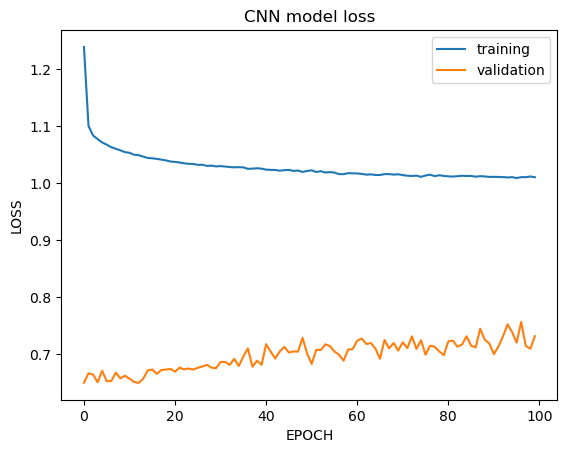

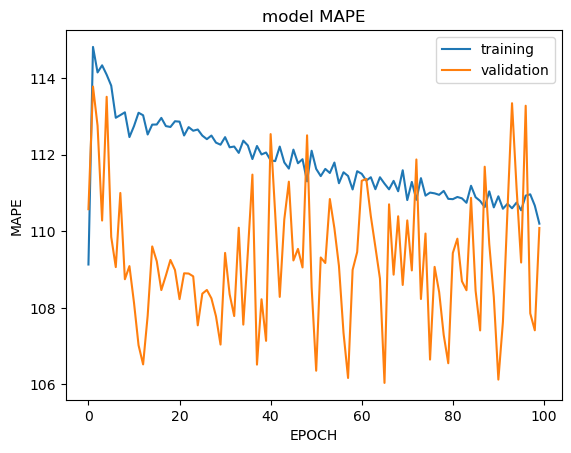

In [95]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN model loss')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['training', 'validation'])
plt.show()

# summarize history for MAPE
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model MAPE')
plt.ylabel('MAPE')
plt.xlabel('EPOCH')
plt.legend(['training', 'validation'])
plt.show()

We obtain MAPE for train dataset equal to `112.26`% and for test/validation dataset equal to `110.09`%. In original work author declares training MAPE `5.4`% and validation MAPE `4.75`%. However, when we rerun the original R code, we obtain similar results (the training/validation process plots indicate MAPE around 115/110%). The true results of original work could be seen in rendered the original Rmd file - consult `Energy_prediction_original.html` file (we treat it as exemplary result, as in original file the the results are not reproducible).

### Summary

All things considered, we conclude that we managed to accurately reproduce the results in orignal R solution and translated them successfully to Python language.

Throughtout the solution translation we indicated inconsistencies and code chunks that should/could be modified in order to provide clarity, and, eventually, simplicity of the analysis. This file is fully reproducible (we employed random seeds in appropriate code chunks). 

This file is a basis for the improved version of the analysis, where we are going to divide the code to appropriate parts, use modular coding, develop functions for preparing / modelling externally and extend the analysis present here. Moreover, we are going to make the analysis simpler and thus we will be able to omit mistakes present here (excluding inappropriate variables in feature selection / assigning wrong dependent variable for CNN model etc.).